In [38]:
#import libraries
import os
import pandas as pd
import numpy as np
import string
import regex as re
import itertools
from datetime import datetime
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#conda install -c conda-forge wordcloud
from wordcloud import WordCloud     #Install wordcloud using conda using 'conda install -c conda-forge wordcloud'
#pip install num2words
from num2words import num2words

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read Data

In [2]:
#Read data

folder = os.getcwd()
Fake_data_file_name = 'Fake.csv'
True_data_file_name = 'True.csv'

if os.path.isfile(Fake_data_file_name):
    fake = pd.read_csv(Fake_data_file_name)
else:
    print ("Error: Fake.csv does not exist in ", folder)
    
if os.path.isfile(True_data_file_name):
    true = pd.read_csv(True_data_file_name)
else:
    print ("Error: True.csv does not exist in ", folder)


In [3]:
# Flag added to differentiate fake and real data. This is the target variable
fake['target'] = 'FAKE'
true['target'] = 'REAL'

In [4]:
data = pd.concat([fake, true]).reset_index(drop = True)

# Shuffle data to prevent bias
data = shuffle(data)
data = data.reset_index(drop = True)

In [158]:
#text = text.apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] ))
#text = text.apply(punctuation_removal)
#text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#data = convert_lower_case(data)
 #   data = remove_punctuation(data)
  #  data = remove_apostrophe(data)
  #  data = remove_single_characters(data)
  #  data = convert_numbers(data)
  #  data = remove_stop_words(data)
  #  data = stemming(data)
  # data = remove_punctuation(data)
  #  data = convert_numbers(data)

array('hi"s', dtype='<U4')

## Data Cleaning

In [5]:
def punctuation_removal(text):
    all_list = [char for char in text if char not in "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"]
    clean_str = ''.join(all_list)
    return clean_str

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def Lemmating(data):
    lemmater= WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmater.lemmatize(w)
    return new_text


In [22]:
data['subject'] = data['subject'].replace('politicsNews', 'politics')
data['subject'] = data['subject'].replace('_', '-')

stop = stopwords.words('english')
# remove stopwords
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", '', x, flags=re.MULTILINE))  #remove urls and links
data['text'] = data['text'].apply(convert_numbers)
data['text'] = data['text'].apply(Lemmating)
data['text'] = data['text'].apply(punctuation_removal)
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data['text'] = data['text'].apply(lambda x: np.char.replace(x, "'", ""))
data['text'] = data['text'].apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] ))


In [7]:
data['date'] = data['date'].str.replace('Jan ', 'January ')
data['date'] = data['date'].str.replace('Feb ', 'February ')
data['date'] = data['date'].str.replace('Mar ', 'March ')
data['date'] = data['date'].str.replace('Apr ', 'April ')
data['date'] = data['date'].str.replace('Jun ', 'June ')
data['date'] = data['date'].str.replace('Jul ', 'July ')
data['date'] = data['date'].str.replace('Aug ', 'August ')
data['date'] = data['date'].str.replace('Sep ', 'September ')
data['date'] = data['date'].str.replace('Oct ', 'October ')
data['date'] = data['date'].str.replace('Nov ', 'November ')
data['date'] = data['date'].str.replace('Dec ', 'December ')
data.date = data.date.str.strip()
data = data[data.date.str.len() <= 18]  #drop values where the data is not correct in Date field
data.date = data.date.apply(lambda x: datetime.strptime(x, "%B %d, %Y") if (len(x) > 9 & len(x) < 18) else datetime.strptime(x, "%d-%b-%y"))

data['year'] = data['date'].dt.to_period('Y')
data['month'] = data['date'].dt.to_period('M')
data['month'] = data['month'].astype(str)

In [35]:
data

,title,text,subject,date,target,year,month
0,"Trump INFURIATES Intelligence Community, Puts...",donald trump easily least qualified candidate...,News,2016-11-24,FAKE,2016,2016-11
1,LIBERAL LOSER Screams “This is my America!” Af...,,politics,2016-12-19,FAKE,2016,2016-12
2,Trump Outrageously Refers To Elizabeth Warren...,totally unpresidential behaviorthroughout cam...,News,2017-02-11,FAKE,2017,2017-02
3,BOMBSHELL: Top Trump Appointment Was HUGE Don...,linda mcmahon trump pick head small business ...,News,2016-12-08,FAKE,2016,2016-12
4,Trump has 'friendly' call with Mexican leader ...,washington reuters presidents united states m...,politics,2017-01-27,TRUE,2017,2017-01
5,"Facing potential wheat crisis, Egypt plays dow...",cairo reuters poppy seeds found two cargoes i...,worldnews,2017-09-13,TRUE,2017,2017-09
6,WATCH: Democrat Takes Michigan Gov. Rick Snyd...,one glorious opening statement rep elijah cum...,News,2016-03-17,FAKE,2016,2016-03
7,Ukraine's Poroshenko suggests IMF-backed anti-...,kiev reuters ukrainian president petro porosh...,worldnews,2017-09-15,TRUE,2017,2017-09
8,WATCH What Hillary Says About Trump’s Bigoted...,hillary clinton launched first ad directly ai...,News,2016-03-30,FAKE,2016,2016-03
9,Trump's EPA pick may struggle to dismantle Oba...,washington reuters scott pruitt donald trump ...,politics,2016-12-09,TRUE,2016,2016-12


## Data Exploration

subject
Government News     1568
Middle-east          778
News                9050
US_News              783
left-news           4456
politics           18108
worldnews          10145
Name: text, dtype: int64


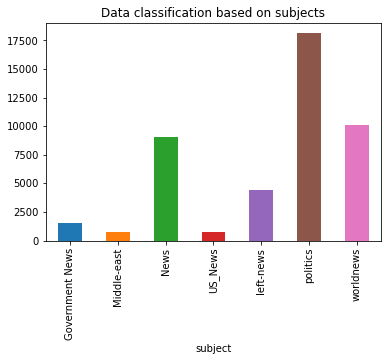

In [132]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.title("Data classification based on subjects")
plt.show()

Text(0.5, 1.0, 'Dynamics of news articles')

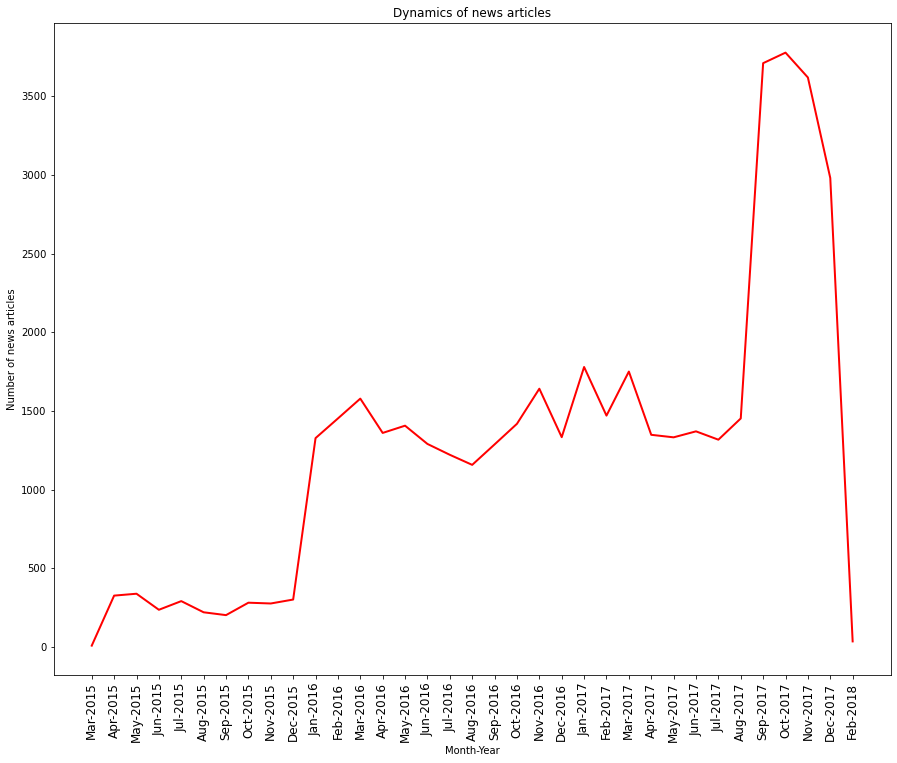

In [113]:
monthly_data = data.groupby(['month'])['text'].count()
monthly_data = monthly_data.reset_index(level=0)
monthly_data.month = pd.to_datetime(monthly_data.month)
monthly_data.month = monthly_data.month.apply(lambda x: x.strftime("%b-%Y"))
plt.figure(figsize=(15,12))
plt.xticks(rotation=90)
plt.ylabel('Number of news articles')
plt.xlabel('Month-Year')
plt.tick_params(axis='x', which='major', labelsize=12)
plt.plot(monthly_data.month, monthly_data.text, linewidth=2, color='red')
plt.title('Dynamics of news articles')

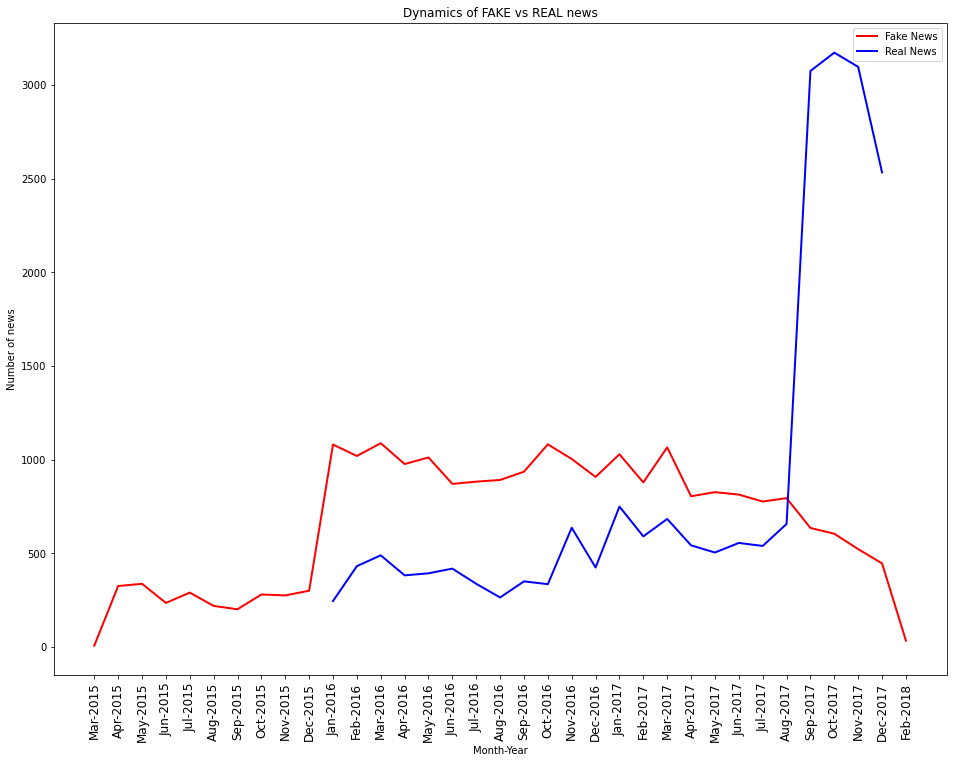

In [114]:
monthly_data_by_target = data.groupby(['month', 'target'])['text'].count()
monthly_data_by_target = monthly_data_by_target.reset_index(level=0)
monthly_data_by_target.month = pd.to_datetime(monthly_data_by_target.month)
monthly_data_by_target.month = monthly_data_by_target.month.apply(lambda x: x.strftime("%b-%Y"))
fake_monthly_data = monthly_data_by_target[monthly_data_by_target.index == 'FAKE']
real_monthly_data = monthly_data_by_target[monthly_data_by_target.index == 'REAL']
plt.figure(figsize=(16,12))
plt.xticks(rotation=90)
plt.ylabel('Number of news')
plt.xlabel('Month-Year')
plt.tick_params(axis='x', which='major', labelsize=12)
plt.plot(fake_monthly_data.month, fake_monthly_data.text, linewidth=2, color='red', label='Fake News')
plt.plot(real_monthly_data.month, real_monthly_data.text, linewidth=2, color='blue', label='Real News')
plt.title('Dynamics of FAKE vs REAL news')
plt.legend()
plt.show()

target
FAKE    23471
REAL    21417
Name: text, dtype: int64


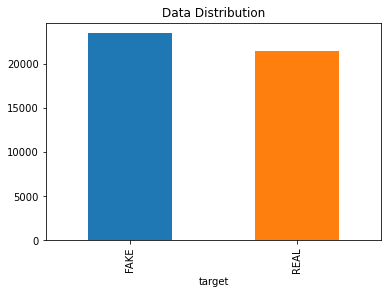

In [131]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.title("Data Distribution")
plt.show()

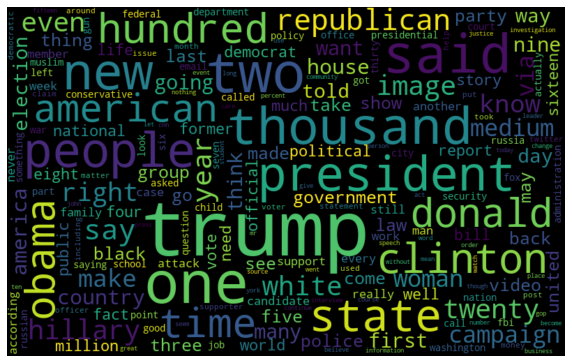

In [24]:
# Wordcloud for Fake News
fake_data = data[data["target"] == "FAKE"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud_fake = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

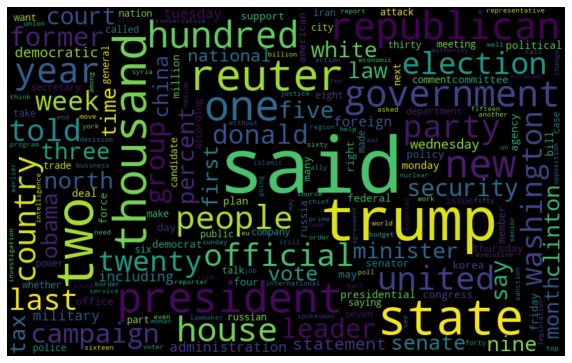

In [25]:
# Wordcloud for Real News
real_data = data[data['target'] == 'REAL']
all_words = ' '.join([text for text in real_data.text])

wordcloud_true = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis("off")
plt.show()

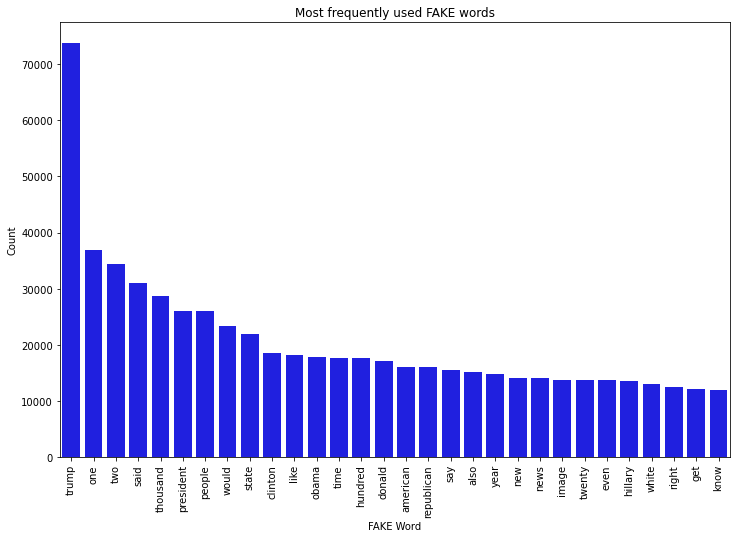

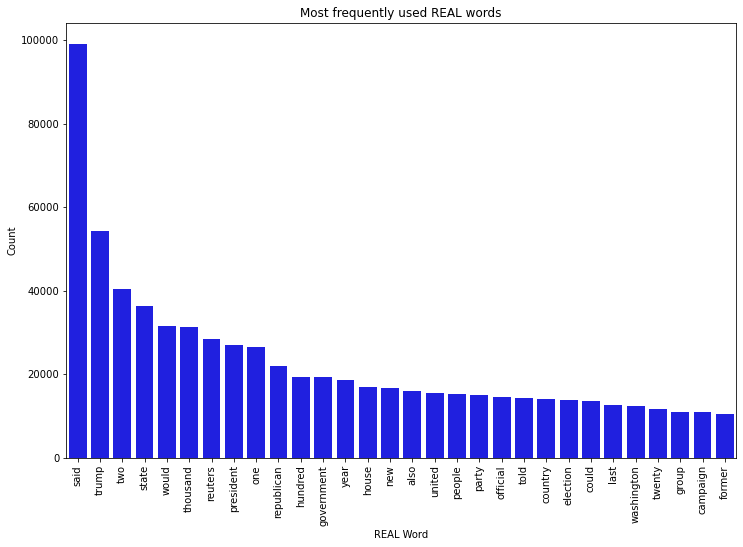

In [126]:
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity, category):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})    
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count", xlabel = (category + " Word"))
    plt.xticks(rotation='vertical')
    plt.title("Most frequently used " + category +" words")
    plt.show()
    
counter(data[data["target"] == "FAKE"], "text", 30, "FAKE")
counter(data[data["target"] == "REAL"], "text", 30, "REAL")

# Data Modelling

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [100]:
def predict_model(model, target):
    
    # Predict the model for selected target
    prediction = model.predict(target)    
    return prediction

In [152]:
def convert_text_to_int(input):
    results = []
    for i in input:
        if i == "FAKE":
            results.append(0)
        else:
            results.append(1)
            
    return results

def calculate_roc_curve(model_name, arr, x_label):
    train_results = []
    test_results = []
    for ar in arr:
        if model_name == "SVM":
            pipe = construct_svm_model(ar)
        elif model_name == "DT":
            pipe = construct_dt_model(ar)
        elif model_name == "RF":
            pipe = construct_rf_model(ar)
        elif model_name == "NB":
            pipe = construct_nb_model(ar)
        else:
            print("Model Not supported for ROC Curve. Please enter one among - SVM, DT, RF, NB.")
            break 
                
        # Predict model
        train_prediction = predict_model(pipe, X_train)
        test_prediction = predict_model(pipe, X_test)
        
        # Convert prediction results to numeric format        
        train_pred = convert_text_to_int(train_prediction)
        test_pred = convert_text_to_int(test_prediction)
        train_target = convert_text_to_int(y_train)
        test_target = convert_text_to_int(y_test)
        
        # Calculate ROC and Area Under Curve (AUC) for training and test data
        false_positive_rate, true_positive_rate, thresholds = roc_curve(train_target, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target, test_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    plt.plot(arr, train_results, linewidth=2, color='red', label='Train AUC')
    plt.plot(arr, test_results, linewidth=2, color='blue', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel(x_label)
    plt.legend()
    plt.show()
        

In [17]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# TF-IDF Method

In [118]:
def construct_tfidf_model():
    pipe = Pipeline([('vect', CountVectorizer()),  #convert text to a matrix of token counts
                 ('tfidf', TfidfTransformer()), #transform a count matrix to a normalized tf-idf representation
                 ('model', LogisticRegression(random_state = 0))])
    
    # Fitting the model
    pipe.fit(X_train, y_train)

    return pipe

# Create model
pipe_tfidf = construct_tfidf_model()
# Accuracy
prediction_tfidf = predict_model(pipe_tfidf, X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction_tfidf)*100,2)))

accuracy: 98.92%


Confusion matrix, without normalization


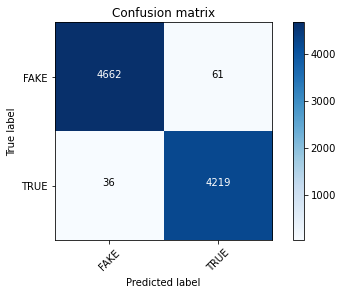

In [33]:
cm = metrics.confusion_matrix(y_test, prediction_tfidf)
plot_confusion_matrix(cm, classes=['FAKE', 'TRUE'])

# Support Vector Machine

In [154]:
def construct_svm_model(C):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC(C=C))])
    
    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_svm = construct_svm_model(0.1)
# Accuracy
prediction_svm = predict_model(pipe_svm, X_test)
print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction_svm)*100,2)))

accuracy: 99.23%


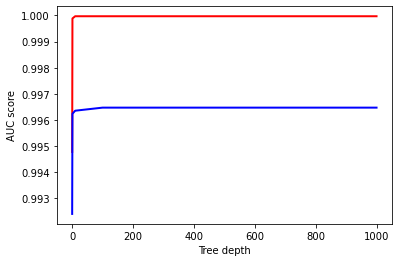

In [101]:
calculate_roc_curve("SVM", [0.1, 1, 10, 100, 1000], 'Regularization Parameter (C)')

The model is overfit as C increases. This is inline with expected results from sklearn documentation.

Confusion matrix, without normalization


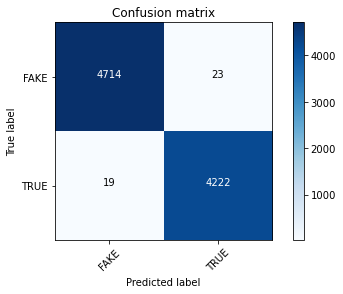

In [20]:
cm = metrics.confusion_matrix(y_test, prediction_svm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Decision Tree Classifier

In [150]:
def construct_dt_model(max_depth):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = max_depth, 
                                           splitter='best', 
                                           random_state=42))])
    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_dt = construct_dt_model(7)
# Accuracy
prediction_dt = predict_model(pipe_dt, X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction_dt)*100,2)))

accuracy: 99.57%


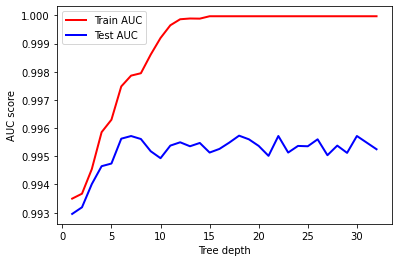

In [103]:
calculate_roc_curve("DT", np.linspace(1, 32, 32, endpoint=True), 'Tree depth')

Our Decision Tree model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data. Beyond the depth of 8, the model starts to become overfit 

Confusion matrix, without normalization


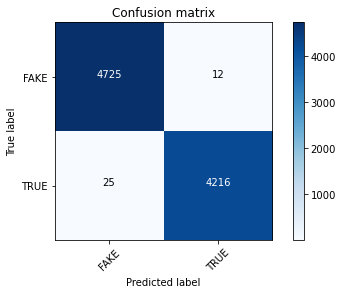

In [22]:
cm = metrics.confusion_matrix(y_test, prediction_dt)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Random Forest Classifier

In [157]:
def construct_rf_model(estimators):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(
                                 n_estimators=estimators, #Adding max_dept is reducing the accuracy to less than 94%
                                 criterion="entropy", 
                                 random_state = 0))])
    
    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_rf = construct_rf_model(17)
# Accuracy
prediction_rf = predict_model(pipe_rf, X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction_rf)*100,2)))

accuracy: 98.43%


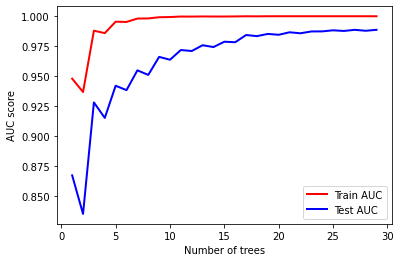

In [148]:
calculate_roc_curve("RF", list(range(1, 30)), 'Number of trees')

As the max_depth increases, the model starts to become overfit

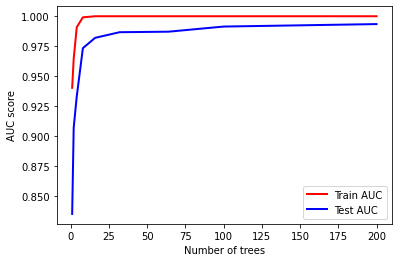

In [107]:
calculate_roc_curve("RF", [1, 2, 4, 8, 16, 32, 64, 100, 200], 'Number of trees')

With more number of estimators, the model is becoming overfit. So, the optimal number is 17.

Confusion matrix, without normalization


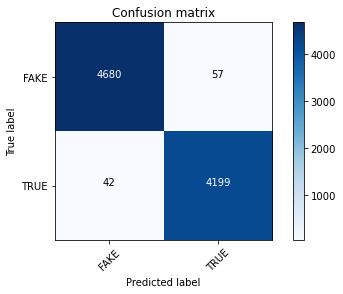

In [24]:
cm = metrics.confusion_matrix(y_test, prediction_rf)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Naive Bayes Classifier

In [127]:
def construct_nb_model(alpha):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB(alpha = alpha))])  # alpha = 1 - Laplace smoothing, alpha < 1 - Lidstone smoothing
    
    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_nb = construct_nb_model(0.01)
# Accuracy
prediction_nb = predict_model(pipe_nb, X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction_nb)*100,2)))

accuracy: 96.77%


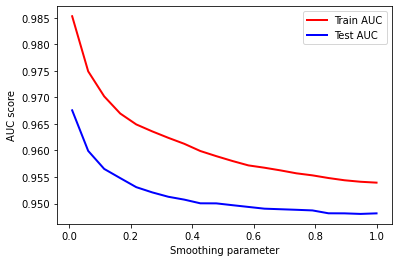

In [129]:
calculate_roc_curve("NB", np.linspace(0.01, 1, 20, endpoint=True), 'Smoothing parameter')

As the smoothing parameter is increased, the model is not able to learn enough about the data. This is causing underfitting. 

Confusion matrix, without normalization


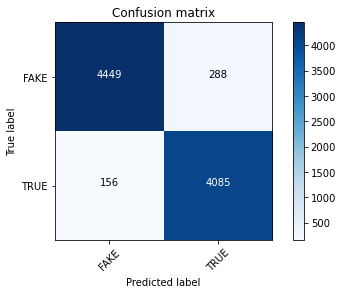

In [26]:
cm = metrics.confusion_matrix(y_test, prediction_nb)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [147]:
list(range(1, 30))

[1, 2, 3, 4]

In [ ]:
# TODO: Analyse which method is best. 
# Take few websites to predict if the article is real or fake
# More classifier details - https://www.datacamp.com/community/tutorials/scikit-learn-fake-news